# ETL Hourly Weather Data Per Airport
Local Climatological Data (LCD) can be found on NOAA's website: https://www.ncdc.noaa.gov/cdo-web/datatools/lcd. All times provided are in local standard time. It is more convenient to download the archive weather data (https://www.ncei.noaa.gov/data/local-climatological-data/archive/) which is physically partitioned by year and station number. Mapping of station identification number to airport IATA codes can be found at: https://www.ncdc.noaa.gov/data-access/land-based-station-data/station-metadata (download isd-history.txt). There may be overlap between multiple station numbers and IATA codes over the same period of time.  

Data pre-processing is performed to read data directly from within the compressed archive files (YYYY.tar.gz) and transform it into parquet for subsequent processing. Fully extracting the weather data requires >20GB per year since ~10k station files are included. Data down-selection is applied to filter for the stations that correspond to ~400 airports in the BTS Airline On-Time Performance dataset. Pandas merge_asof() is applied to impute missing times within a few hours of the data gap. Larger gaps are assumed to be nominal conditions (e.g., clear sky, full visibility, etc.) for irregularly occurring attributes. Interpolation is applied to continuous attributes (only HourlyDryBulbTemperature at the moment), however, a seasonality model would be needed to fill larger data gaps.  

In [1]:
import os
import io
import sys
import glob
import shutil
import tarfile
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pandas.api.types import CategoricalDtype
import numpy as np
from functools import reduce
from time import time
import re
from scipy.interpolate import interp1d

import dask
import dask.dataframe as dd
from dask.distributed import Client, wait, progress, get_worker


analysis_years = np.arange(2021,2022,1)

# Directory of archive LCD weather data:
wx_raw_data_dir = './data/raw/weather/noaa_lcd_archive/'
wx_processed_data_dir = './data/converted/weather/NAS/'
os.makedirs(wx_processed_data_dir, exist_ok = True)

# Write intermediate parquet file to tmp:
tmp_wx_output_dir = './tmp/wx_archive_parquet/' # DATA WILL BE WIPED WITH EACH RUN
os.makedirs(tmp_wx_output_dir, exist_ok = True)

use_cols = ['STATION', 'DATE', 'REPORT_TYPE', 
            'HourlyDryBulbTemperature', 'HourlyPresentWeatherType', 'HourlySkyConditions', 
            'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyVisibility', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed'
           ]

# HourlyRelativeHumidity has a lot of missing values (73k/161k hours missing). Would be difficult to impute so should be removed.
# HourlyPresentWeatherType: needs to be decoded.
# HourlySkyConditions: needs to be decoded. Probably care about SEVERE weather which is likely sparse.

client = Client(n_workers=4, threads_per_worker=16) # Good for DSWS.
client

/home/btong/miniconda3/envs/rapids-21.12/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46881 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46881/status,
Dashboard: http://127.0.0.1:46881/status,Workers: 4
Total threads: 64,Total memory: 251.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37105,Workers: 4
Dashboard: http://127.0.0.1:46881/status,Total threads: 64
Started: Just now,Total memory: 251.65 GiB
Comm: tcp://127.0.0.1:35005,Total threads: 16
Dashboard: http://127.0.0.1:39653/status,Memory: 62.91 GiB
Nanny: tcp://127.0.0.1:37579,


In [2]:
station_file = './data/raw/weather/isd-history.txt'
station_df = pd.read_fwf(station_file, skiprows=20).drop(0)
station_df['WBAN'] = station_df['WBAN'].astype(int)

# Multiple USAF/WBAN code can correspond to same CALL since station can be moved. Check BEGIN/END date to make sure data still valid for interested airports.
station_df['IATA'] = station_df['CALL'].str[1:] # Approximate by dropping first letter
station_df['STATION'] = station_df['USAF'].astype(str) + station_df['WBAN'].astype(str).str.zfill(5)
station_df['IATA_ST'] = station_df['IATA'] + '_' + station_df['ST']

# Identify unique airports within data:
flt_pq_output_dir = './data/converted/flight'
flt_data = dd.read_parquet(flt_pq_output_dir, columns=['DEST', 'ORIGIN']).categorize()
od_arpt = sorted(set(flt_data['ORIGIN'].cat.categories.values) | set(flt_data['DEST'].cat.categories.values))
# print('NAS ORIGIN/DEST airports:', od_arpt)

# Filter for NAS airports:
station_df = station_df[station_df['IATA_ST'].isin(od_arpt)]

# Airports without wx data:
print('Airports without weather data:', sorted(set(od_arpt) - set(station_df['IATA_ST'])))

station_df

Airports without weather data: ['AZA_AZ', 'BET_AK', 'BQN_PR', 'BRW_AK', 'CDB_AK', 'CDV_AK', 'DLG_AK', 'FAI_AK', 'FCA_MT', 'GUM_TT', 'HHH_SC', 'ITO_HI', 'JNU_AK', 'KOA_HI', 'KTN_AK', 'LIH_HI', 'OGG_HI', 'OME_AK', 'OTZ_AK', 'PSE_PR', 'PSG_AK', 'SCC_AK', 'SCE_PA', 'SIT_AK', 'SJU_PR', 'SPN_TT', 'STT_VI', 'STX_VI', 'USA_NC', 'WRG_AK', 'XWA_ND', 'YAK_AK']


,USAF,WBAN,STATION NAME,CTRY,ST,CALL,LAT,LON,ELEV(M),BEGIN,END,IATA,STATION,IATA_ST
15316,702730,26451,TED STEVENS ANCHORAGE I,US,AK,PANC,61.169,-150.028,36.6,19730101.0,20210515.0,ANC,70273026451,ANC_AK
15382,703260,25503,KING SALMON AIRPORT,US,AK,PAKN,58.683,-156.656,20.4,19420110.0,20210515.0,AKN,70326025503,AKN_AK
15401,703500,25501,KODIAK AIRPORT,US,AK,PADQ,57.751,-152.486,24.4,19450101.0,20210515.0,ADQ,70350025501,ADQ_AK
15472,704540,25704,ADAK NAS,US,AK,PADK,51.883,-176.650,5.2,19421030.0,20210515.0,ADK,70454025704,ADK_AK
15473,704540,99999,ADAK (NAS),US,AK,PADK,51.883,-176.650,5.0,20000101.0,20031231.0,ADK,70454099999,ADK_AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29505,999999,94849,ALPENA PHELPS COLLINS F,US,MI,KAPN,45.072,-83.564,211.2,19590901.0,19721231.0,APN,99999994849,APN_MI
29506,999999,94860,GRAND RAPIDS KENT COUNT,US,MI,KGRR,42.883,-85.524,244.8,19631201.0,19721231.0,GRR,99999994860,GRR_MI
29510,999999,94908,DUBUQUE MUNICIPAL AP,US,IA,KDBQ,42.398,-90.704,329.2,19510201.0,19721231.0,DBQ,99999994908,DBQ_IA
29511,999999,94910,WATERLOO MUNICIPAL AP,US,IA,KALO,42.554,-92.401,267.6,19490101.0,19721231.0,ALO,99999994910,ALO_IA


# Convert tar.gz Archived CSV to Parquet:

In [3]:
%%time

def wx_tar_to_df(tar, fn_list, usecols, output_dir):
    """
    Read csv within tar file and convert results to a dataframe.
    
    tar: tarfile object
        tarfile object that is open for reading.
    fn: str
        Filename of csv file within tarfile
    usecols: list
        Columns to read within csv.
    """
    tmp_ = []
    for fn in fn_list:
        tmp_.append(pd.read_csv(io.BytesIO(tar.extractfile(fn).read()), usecols=usecols, low_memory=False, dtype=str))
    
    out = pd.concat(tmp_)
    out['STATION'] = out['STATION'].astype(str) # STATION identifier can be str. Need consistent dtype for merging.
    out.to_parquet(output_dir)
    return()

@dask.delayed
def process_wx_targz(cur_year):
    """
    Process individual tar.gz weather archive files. Dask cannot serialize tarfile, so can only parallelize individual year archives.
    """
    tar = tarfile.open(wx_raw_data_dir+str(cur_year)+'.tar.gz', 'r')
    weather_files = tar.getnames() # Takes about 1 minute to get filenames?

    # Read and convert files using dask. Split workload based on number of files.
    toc = pd.DataFrame(weather_files)
    toc.columns = ['filename']
    toc['STATION'] = toc['filename'].str.split('.').str[0]

    # Process stations corresponding to flight records:
    toc = toc[toc['STATION'].isin(station_df['STATION'])]
    
    wx_data = wx_tar_to_df(tar, list(toc['filename']), use_cols, tmp_wx_output_dir+str(cur_year)+'.parquet')
    return()


# Check if data exists in weather data output directory:
num_pq_files = len(glob.glob(tmp_wx_output_dir+'/*.parquet'))

if num_pq_files == len(analysis_years):
    print('Expected number of parquet files detected in weather output temp directory. Parquet conversion skipped.')
    
else:
    # Remove and remake directory:
    try:
        # RECURSIVELY DELETE DIRECTORY and then add it
        shutil.rmtree(tmp_wx_output_dir)
    except:
        pass

    os.mkdir(tmp_wx_output_dir)

    # Process weather data from annual zip archive file. Need to also merge station number with common name. 
    # ~10.6k stations/files in 2003 LCD archive. Select only relevant files based on available flight data (e.g., ~400 airports).

    # Dask currently only used for tar.gz processing. 
#     n_workers = 18
#     client = Client(n_workers=n_workers, threads_per_worker=1)
    client = Client()
    
    tic = time()
    dask_tasks = [process_wx_targz(yr) for yr in analysis_years]
    dask.compute(dask_tasks)
    t_tar_conversion = time() - tic
    print('tar.gz to parquet conversion time:', np.round(t_tar_conversion,2))
    client.close()
    
# Parquet conversion takes ~13 minutes for 16-yr data running on 18 cores (1-core per year). A lot of time is spent on tar.getnames() within archive.

/home/btong/miniconda3/envs/rapids-21.12/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35165 instead
  warnings.warn(


tar.gz to parquet conversion time: 9.35
CPU times: user 721 ms, sys: 327 ms, total: 1.05 s
Wall time: 10.1 s


# Load Parquet Weather Data and Run ETL

In [4]:
%%time
wx_data = dd.read_parquet(tmp_wx_output_dir)

# Get start/end times for hourly resampling. Faster to compute before running other dask operations.
wx_start = pd.to_datetime(np.min(wx_data['DATE']).compute())
wx_end = pd.to_datetime(np.max(wx_data['DATE']).compute()) + pd.Timedelta('1D')

# Merge station info:
# wx_data = wx_data.merge(station_df[['STATION', 'IATA_ST', 'CALL', 'BEGIN', 'END']], on='STATION', how='left')
wx_data = wx_data.merge(station_df[['STATION', 'IATA_ST']], on='STATION', how='left')
# wx_data.loc[wx_data['IATA_ST'].isna(), 'IATA_ST'] = wx_data.loc[wx_data['IATA_ST'].isna(), 'STATION']

# Source Type: https://www1.ncdc.noaa.gov/pub/data/ish/ish-format-document.pdf
#  SOM: Summary of Month
#  SOD: Summary of Day
#  FM-15: METAR Aviation routine weather report
#  FM-16: SPECI Aviation selected special weather report

use_report_type = ['FM-12', 'FM-15', 'FM-16', 'SY-MT']
# wx_data = wx_data[wx_data['REPORT_TYPE'].isin(use_report_type)] # .isin() has issues when using dask.dataframe.
wx_data = wx_data.query("REPORT_TYPE=='FM-12' or REPORT_TYPE=='FM-15' or REPORT_TYPE=='FM-16' or REPORT_TYPE=='SY-MT'")
wx_data['DATE'] = dd.to_datetime(wx_data['DATE'])
wx_data['DATE_HR_orig'] = wx_data['DATE'].dt.round('1H')
wx_data = wx_data.sort_values('DATE')

wx_grp = wx_data.groupby('IATA_ST')

print('Unique REPORT_TYPE:', wx_data['REPORT_TYPE'].unique())
# # Estimate number of unique hourly samples at each station:
# num_records_orig = len(wx_data[['IATA_ST', 'DATE_HR_orig', 'STATION']].groupby(['IATA_ST', 'DATE_HR_orig']).last())
# print('Number of original data samples:', num_records_orig)

Unique REPORT_TYPE: Dask Series Structure:
npartitions=1
    object
       ...
Name: REPORT_TYPE, dtype: object
Dask Name: unique-agg, 14 tasks
CPU times: user 71 ms, sys: 4.53 ms, total: 75.5 ms
Wall time: 542 ms


In [5]:
%%time

def process_sky_condition(weather_df):
    def parse_HourlySkyConditions(input_str):
        """Parse HourlySkyConditions from NOAA LCD data."""
        if input_str != None:
            dc_list = input_str.split(' ')
            if len(dc_list) > 1:
                out = list(zip(dc_list[::2], dc_list[1::2]))
            else:
                out = None
        else:
            out = None
        return(out)
    # Process HourlySkyConditions by pre-filtering for non-NA's.
    sky_condition = weather_df[~weather_df['HourlySkyConditions'].isna()]['HourlySkyConditions']
    sky_condition = sky_condition.apply(parse_HourlySkyConditions)
    sky_condition = sky_condition[~sky_condition.isna()] # Remove NA's introduced during parsing
    sky_condition = sky_condition.explode()
    sky_condition = sky_condition.reset_index()

    sky_condition_sm = pd.DataFrame(list(sky_condition['HourlySkyConditions'].values), columns=['HourlySkyConditions_cover', 'HourlySkyConditions_height'])
    sky_condition_sm['HourlySkyConditions_height'] = sky_condition_sm['HourlySkyConditions_height'].str.replace('s|\*','0', regex=True)
    sky_condition_sm['DATE'] = sky_condition['DATE']

    # Restrict valid value of field based on str length:
    sky_condition_sm['cover_len'] = sky_condition_sm['HourlySkyConditions_cover'].str.len()
    sky_condition_sm = sky_condition_sm[sky_condition_sm['cover_len'].between(5,6)]

    # Ensure unique HourlySkyConditions_cover per hour (e.g., okay to have one of each type, but not multiples). Use last known update.
    sky_condition_sm = sky_condition_sm.groupby(['DATE', 'HourlySkyConditions_cover'], as_index=False).last()
#     print('Sky Condition categories after filtering:')
#     print(sky_condition_sm['HourlySkyConditions_cover'].value_counts())
#     print()

    # Truncate before the ':' to get larger grouping.
    sky_condition_sm['HourlySkyConditions_cover'] = sky_condition_sm['HourlySkyConditions_cover'].str.split(':').str[0]
#     print('Sky Condition categories after combining:')
#     print(sky_condition_sm['HourlySkyConditions_cover'].value_counts())
#     print()

    sky_condition_pv = sky_condition_sm.pivot(columns=['HourlySkyConditions_cover'], values='HourlySkyConditions_height').fillna(0)
    sky_condition_pv.columns = 'HourlySkyCover_'+sky_condition_pv.columns
    sky_condition_pv = sky_condition_pv.merge(sky_condition_sm['DATE'], left_index=True, right_index=True, how='left').set_index('DATE')
    sky_condition_pv = sky_condition_pv.replace('', '0').astype('int16') # int8 [-128,127], but range of data range is [0,350]. 
    
#     sky_condition_pv = sky_condition_pv.drop(columns=['HourlySkyCover_CLR', 'HourlySkyCover_X'])
    sky_condition_pv = sky_condition_pv.drop([cc for cc in ['HourlySkyCover_CLR', 'HourlySkyCover_X'] if cc in sky_condition_pv.columns], axis=1)
    
    return(sky_condition_pv)

def process_present_wx(weather_df):
    def parse_HourlyPresentWeatherType(input_str):
        """
        Parse HourlyPresentWeatherType from NOAA LCD data.
        AU|AW|MW for Automatic and Manual reporting. Simplify by dropping +- and numeric portion. Merge unique letter codes in all split fields.
        """
        if input_str != None:
            dc_list = list(set(re.sub('[\|+-:]', '', input_str).split(' ')))
            if len(dc_list) > 0:
                out = dc_list
            else:
                out = None
        else:
            out = None
        return(out)

    # Process HourlyPresentWeatherType:
    present_wx_type = weather_df[~weather_df['HourlyPresentWeatherType'].isna()]['HourlyPresentWeatherType']
#     print('Top 10 HourlyPresentWeatherType:')
#     print(present_wx_type.value_counts()[:10])
#     print()

    present_wx_type = present_wx_type.apply(parse_HourlyPresentWeatherType).reset_index()
    present_wx_type['tmp'] = 1 # Used in pivot operation

    # Expansion via OHE might be too sparse. There are 24 associated columns. 
    # Use alphabetical ordered list for each condition, then reduce list to single string.
    present_wx_type['HourlyPresentWeatherTypeCombo'] = present_wx_type['HourlyPresentWeatherType'].apply(lambda x: '_'.join(list(set(x))))

    # OHE expansion of HourlyPresentWeatherType too sparse. Use explicit combinations and TargetEncode. 
#     present_wx_type_pv = present_wx_type.explode('HourlyPresentWeatherType').pivot(columns=['HourlyPresentWeatherType'], values='tmp')

#     try:
#         present_wx_type_pv = present_wx_type_pv.drop(columns = ['', '*', 's'])
#     except:
#         pass

#     present_wx_type_pv = present_wx_type_pv.fillna(0).astype('int16')

#     # Merge weather data:
#     present_wx_type_pv = (present_wx_type[['DATE', 'tmp']]
#                           .merge(present_wx_type_pv, left_index=True, right_index=True, how='left')
#                           .drop(columns='tmp')
#                           .set_index('DATE')
#                          )

#     present_wx_type_pv.columns = 'HourlyPresentWeatherType_' + present_wx_type_pv.columns
    return(present_wx_type)

def fix_numeric_dtypes(weather_df):
    weather_df = weather_df.drop(columns=['HourlySkyConditions', 'HourlyPresentWeatherType'])
#     print(weather_df.dtypes)
    
    # Remove characters like T|V|s from the numerical fields:
    for cc in numeric_cols:
        # Replace missing data string as np.nan:
        weather_df[cc] = weather_df[cc].replace('None|''', np.nan)        
        
        try:
            # Handle case where column not recognized as str type. Maybe it's completely empty. 
            if cc == 'HourlyPrecipitation':
                weather_df[cc] = weather_df[cc].str.split('.').apply(lambda x: '.'.join(x[:2]) if x != None else '0')

            elif cc == 'HourlyWindDirection':
                # Replace variable wind direction.
                weather_df[cc] = weather_df[cc].str.replace('VRB','0')
        except:
            pass
            
        try:
            weather_df[cc] = weather_df[cc].str.replace('s|T|V|\*','', regex=True)
        except:
            pass

        weather_df.loc[weather_df['HourlyPressureChange'].isin(['-', '+']), 'HourlyPressureChange'] = 0
        weather_df[cc] = weather_df[cc].replace('', np.nan).astype('float32')


    # Fix nan representation in float, then convert to int:
    zero_na_fill_cols = ['HourlyPrecipitation', 'HourlyPressureChange', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyWindGustSpeed']
    weather_df[zero_na_fill_cols] = weather_df[zero_na_fill_cols].fillna(0)
    weather_df['HourlyVisibility'] = weather_df['HourlyVisibility'].fillna(10) # Assume clear visibility if not provided
    
    # TODO: better imputation of missing numerics using seasonality model. Entire days could be missing so backf/forward filling not possible.
    # Should use daily average or adjacent day average to avoid abrupt change.
    
    # Cast int fields to reduce storage:
    for cc in col_dtypes['int16']:
        weather_df[cc] = weather_df[cc].astype('int16')
    
    return(weather_df)

col_dtypes = {'int16': ['HourlyWindDirection', 'HourlyWindSpeed'],
              'float32': ['HourlyDryBulbTemperature', 'HourlyPressureChange', 'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWindGustSpeed']
             }

numeric_cols = reduce(lambda x,y: x+y, col_dtypes.values())
print('Numeric columns:', numeric_cols)


def process_each_arpt(sgl_arpt_wx):
    # Match non-uniform sampling of weather data to closest observation on common hourly timeline.
    hourly_df = pd.DataFrame({'DATE': pd.date_range(start=wx_start, 
                            end=wx_end, freq='1H')})
    # Setting tolerance is required due to missing data at certain airports.
    sgl_arpt_wx = pd.merge_asof(hourly_df, sgl_arpt_wx, on='DATE', direction='nearest', tolerance=pd.Timedelta('6H')
                               ).drop(columns='REPORT_TYPE').set_index('DATE').sort_index()
    
    # merge_asof doesn't produce unique timestamps. Need to select last().
    sgl_arpt_wx = sgl_arpt_wx.groupby(sgl_arpt_wx.index).last()
    
    # Certain fields will be null due to merge:
    sgl_arpt_wx = sgl_arpt_wx.fillna('')
    
    # TODO: Build seasonality model per numerical column. Then use it to fill missing values.
    # May not be possible to fill in missing sporadic fields like skycover, present weather type, etc.

    # Encode HourlySkyConditions and HourlyPresentWeatherType
    sky_condition_pv = process_sky_condition(sgl_arpt_wx)
    present_wx_type = process_present_wx(sgl_arpt_wx)

    # Apply fixes for numeric dtypes:
    weather_df_fix = fix_numeric_dtypes(sgl_arpt_wx)
    # print(weather_df_fix.isna().sum())
    # print()

    # Chain merge decoded weather fields and fix NA's:
    weather_df_fix_mg = weather_df_fix.merge(sky_condition_pv, left_index=True, right_index=True, how='left')
    weather_df_fix_mg[sky_condition_pv.columns] = weather_df_fix_mg[sky_condition_pv.columns].fillna(0).astype('int16')

    # Use OHE encoding:
    # weather_df_fix_mg = weather_df_fix_mg.merge(present_wx_type_pv, left_index=True, right_index=True, how='left')
    # weather_df_fix_mg[present_wx_type_pv.columns] = weather_df_fix_mg[present_wx_type_pv.columns].fillna(0).astype(bool)
    # weather_df_fix_mg = weather_df_fix_mg.reset_index().rename(columns={'DATE': 'DT_LOCAL'})

    # Use unique string combination:
    weather_df_fix_mg = weather_df_fix_mg.merge(present_wx_type[['DATE', 'HourlyPresentWeatherTypeCombo']], 
                                                left_index=True, right_on='DATE', how='left')
    weather_df_fix_mg['HourlyPresentWeatherTypeCombo'] = weather_df_fix_mg['HourlyPresentWeatherTypeCombo'].fillna('')
    weather_df_fix_mg = weather_df_fix_mg.drop(columns=['STATION'])

    # Reduce storage of data. Currently, rapids conda env doesn't have pyarrow support for uint and halffloats. 
    # f32_cols = list(weather_df_fix_mg.select_dtypes('float32').columns)
    # weather_df_fix_mg[f32_cols] = weather_df_fix_mg[f32_cols].astype('float16')

    weather_df_fix_mg = weather_df_fix_mg.reset_index(drop=True).rename(columns={'DATE': 'DT_LOCAL_HR'})
    weather_df_fix_mg['MISSING_WX'] = weather_df_fix_mg['DATE_HR_orig'] != weather_df_fix_mg['DT_LOCAL_HR'] # Identify imputed hourly weather times
    weather_df_fix_mg = weather_df_fix_mg.drop(columns='DATE_HR_orig')
    
    weather_df_fix_mg.loc[weather_df_fix_mg['MISSING_WX']==True, 'HourlyDryBulbTemperature'] = np.nan
    
    # Some airports do not have sufficient data (e.g., few measurement points; missing year). Avoid extrapolation with unknown time gap.
    # Alternatively, use MISSING_WX field to limit data samples when weather considered.
    try:
        # Assume internal time gaps are not too large. Otherwise, interval needs to be sub-divided.
        # Interpolate hourly values to fill in missing continous attributes:
        valid_sample = weather_df_fix_mg[~weather_df_fix_mg['HourlyDryBulbTemperature'].isna()]

        # Perform cubic fit between valid observations within interval:
        cubic_interp = interp1d(valid_sample.index, valid_sample['HourlyDryBulbTemperature'], kind='cubic')
        
        # Generate interpolated samples within valid interpolation region:
        x_interval = np.arange(valid_sample.index[0], valid_sample.index[-1]+1)
        weather_df_fix_mg.loc[x_interval, 'HourlyDryBulbTemperature'] = cubic_interp(x_interval)
    except:
        pass
    
    # Fill remaining NA's with column average values. Best effort fill was made via cubic interp in valid regions.
    na_mask = weather_df_fix_mg['HourlyDryBulbTemperature'].isna()
    weather_df_fix_mg.loc[na_mask, 'HourlyDryBulbTemperature'] = weather_df_fix_mg['HourlyDryBulbTemperature'].mean()
    weather_df_fix_mg['HourlyDryBulbTemperature'] = weather_df_fix_mg['HourlyDryBulbTemperature'].astype('float32')
    
    weather_df_fix_mg['YEAR'] = weather_df_fix_mg['DT_LOCAL_HR'].dt.year
    weather_df_fix_mg['YEAR'] = weather_df_fix_mg['YEAR'].astype('int16')
    return([weather_df_fix_mg])



try:
    # RECURSIVELY DELETE DIRECTORY and then add it
    shutil.rmtree(wx_processed_data_dir)
except:
    pass

os.mkdir(wx_processed_data_dir)


tic = time() 

# Dask has issues with missing columns (from pivot table) when processing individual airports. Workaround is to wrap dataframe in list.
    # ValueError: The columns in the computed data do not match the columns in the provided metadata
    #   Extra:   ['HourlySkyCover_BKN', 'HourlySkyCover_FEW', 'HourlySkyCover_OVC', 'HourlySkyCover_SCT', 'HourlySkyCover_VV']
    #   Missing: []

# Apply per airport weather processor. Convert results into pandas, otherwise get the following error:
    # NotImplementedError: Series getitem is only supported for other series objects with matching partition structure
wx_per_arpt = wx_grp.apply(process_each_arpt).compute()

# Combine pandas into dask.dataframe:
wx_store = dd.concat([wx_per_arpt[ii][0] for ii in range(len(wx_per_arpt))]).reset_index(drop=True)
wx_store = wx_store.rename(columns={'IATA_ST': 'ARPT_NAME'})

# Repair cols that got lost during merge:
all_skycover_cols = [cc for cc in wx_store.columns if cc.startswith('HourlySkyCover_')]
wx_store[all_skycover_cols] = wx_store[all_skycover_cols].fillna(0).astype('int16')

# Fix remaining uniqueness issues over all airports. Maybe due to temporal merge_asof + interpolation?
wx_store = wx_store.groupby(['ARPT_NAME', 'DT_LOCAL_HR']).last().reset_index()
wx_store = wx_store[wx_store['ARPT_NAME'] != ''] # Remove blank airport name. Spark cannot read it as partition key.

# Repartition and write to disk:
wx_store.repartition(1).to_parquet(wx_processed_data_dir, engine='pyarrow', overwrite=True, 
                                   partition_on=['ARPT_NAME'], flavor='spark', write_metadata_file=False)

t_wx_process = time() - tic
print('Weather processing time:', np.round(t_wx_process,2))

Numeric columns: ['HourlyWindDirection', 'HourlyWindSpeed', 'HourlyDryBulbTemperature', 'HourlyPressureChange', 'HourlyPrecipitation', 'HourlyVisibility', 'HourlyWindGustSpeed']


<timed exec>:246: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU ti

Weather processing time: 34.88
CPU times: user 7.05 s, sys: 550 ms, total: 7.6 s
Wall time: 34.9 s


In [6]:
%%time
# Read processed weather data:
wx_read_proc = dd.read_parquet(wx_processed_data_dir)

num_records_orig = np.sum(~wx_read_proc['MISSING_WX']).compute()
print('Number of ORIGINAL wx observations:', num_records_orig)
print('Total number of wx observations after processing:', len(wx_read_proc))
print('Relative fraction of ORIGINAL wx observations:', num_records_orig/len(wx_read_proc))

# Weather data is incomplete, even at major airports included in BTS data set. May be best to use weather as-is 
# and determine time periods where most weather data available across NAS, simultaneously to investigate weather impacts.
# For demo purposes, imputed weather data can be used to ensure complete temporal coverage. 

Number of ORIGINAL wx observations: 905126
Total number of wx observations after processing: 907188
Relative fraction of ORIGINAL wx observations: 0.9977270422448269
CPU times: user 332 ms, sys: 31 ms, total: 363 ms
Wall time: 973 ms


# Inspect Data

In [8]:
wx_read_proc.describe().compute()

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyVisibility,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,HourlySkyCover_BKN,HourlySkyCover_FEW,HourlySkyCover_OVC,HourlySkyCover_SCT,HourlySkyCover_VV,YEAR
count,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.000000,907188.0
mean,56.727595,0.002582,0.000312,9.306474,161.748124,3.072452,8.270874,6.672493,12.665983,9.695988,13.498761,0.021935,2021.0
std,19.527906,0.026660,0.022583,2.014818,116.942712,8.619223,6.582865,33.505852,46.628157,30.111518,45.372648,0.426463,0.0
min,-29.000000,0.000000,-0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.0
25%,50.000000,0.000000,0.000000,10.000000,110.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.0
50%,66.000000,0.000000,0.000000,10.000000,210.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.0
75%,83.000000,0.000000,0.000000,10.000000,330.000000,23.000000,21.000000,0.000000,30.000000,22.000000,42.000000,0.000000,2021.0
max,155.508087,2.630000,0.370000,53.000000,360.000000,81.000000,2237.000000,350.000000,350.000000,350.000000,350.000000,20.000000,2021.0


In [9]:
wx_read_proc.dtypes

DT_LOCAL_HR                      datetime64[ns]
HourlyDryBulbTemperature                float32
HourlyPrecipitation                     float32
HourlyPressureChange                    float32
HourlyVisibility                        float32
HourlyWindDirection                       int16
HourlyWindGustSpeed                     float32
HourlyWindSpeed                           int16
HourlySkyCover_BKN                        int16
HourlySkyCover_FEW                        int16
HourlySkyCover_OVC                        int16
HourlySkyCover_SCT                        int16
HourlySkyCover_VV                         int16
HourlyPresentWeatherTypeCombo            object
MISSING_WX                                 bool
YEAR                                      int16
ARPT_NAME                              category
dtype: object

In [10]:
wx_read_proc.isna().sum().compute()

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


DT_LOCAL_HR                      0
HourlyDryBulbTemperature         0
HourlyPrecipitation              0
HourlyPressureChange             0
HourlyVisibility                 0
HourlyWindDirection              0
HourlyWindGustSpeed              0
HourlyWindSpeed                  0
HourlySkyCover_BKN               0
HourlySkyCover_FEW               0
HourlySkyCover_OVC               0
HourlySkyCover_SCT               0
HourlySkyCover_VV                0
HourlyPresentWeatherTypeCombo    0
MISSING_WX                       0
YEAR                             0
ARPT_NAME                        0
dtype: int64

<AxesSubplot:>

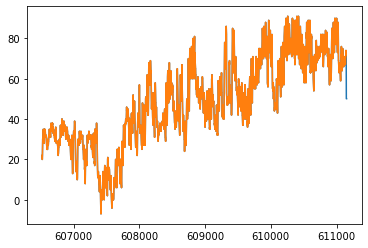

In [12]:
# Plot temperature profile at single airport to confirm best effort interpolation is completed:
sel_arpt = 'ORD_IL'
sgl_arpt_inspect = wx_read_proc[wx_read_proc['ARPT_NAME']==sel_arpt].compute()
sgl_arpt_inspect['HourlyDryBulbTemperature'].plot()
sgl_arpt_inspect[sgl_arpt_inspect['MISSING_WX']==False]['HourlyDryBulbTemperature'].plot()

# YUM became NYL in 2008. Need to create consistent weather station to "airport" mapping.
# Check if NYL used in flight data? Maybe airport move coincide w/ station CALL update.

# TODO: For continuous attributes, should use seasonality model to fill in missing data, including extrapolation.
# Difficult to fill in sporadic fields like sky condition. Should seek out nearby weather data for prioritized substitution.